In [102]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input, LSTM, BatchNormalization, Dropout, Lambda, Multiply, Reshape
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [103]:
def distances_recon_concat_ground_truth(final_df, labeled_anomalies, stream):
    # Extract the anomaly sequences for the given stream
    anomaly_sequences = labeled_anomalies[labeled_anomalies['chan_id'] == stream]['anomaly_sequences'].tolist()

    # Convert the string representation of list to actual list
    actual_anomalies = [eval(seq) for seq in anomaly_sequences]
    
    # Get the number of values for the given stream
    num_values = labeled_anomalies.loc[labeled_anomalies['chan_id'] == stream, 'num_values'].values[0]

    # Initialize a binary array with zeros of length num_values
    binary_labels = np.zeros(num_values)

    # Iterate through all sequences and mark the anomalies
    for anomaly in actual_anomalies:
        for start, end in anomaly:  # Assuming anomaly is a list of [start, end] lists
            binary_labels[start:end + 1] = 1

    # Create a DataFrame from the binary_labels array
    binary_frame = pd.DataFrame(binary_labels, columns=['actual_anomaly'])

    # Concatenate the new binary_frame with the final_df
    final_df = pd.concat([final_df.reset_index(drop=True), binary_frame.reset_index(drop=True)], axis=1)

    return final_df

In [104]:
channel = 'A-7.npy'

In [105]:
parent_dir = os.path.dirname(os.getcwd())
train_df = pd.DataFrame(np.load(os.path.join(parent_dir, 'data','raw','train',f'{channel}')))
test_df = pd.DataFrame(np.load(os.path.join(parent_dir, 'data','raw','test',f'{channel}')))
print("Training data columns:", train_df.shape)
print("Test data columns:", test_df.shape)
labeled_anomalies_file = os.path.join(parent_dir, 'data','processed','labeled_anomalies.csv')
labeled_anomalies = pd.read_csv(labeled_anomalies_file)

Training data columns: (2879, 25)
Test data columns: (8631, 25)


In [106]:
telemetry_train = train_df.iloc[:, 0]

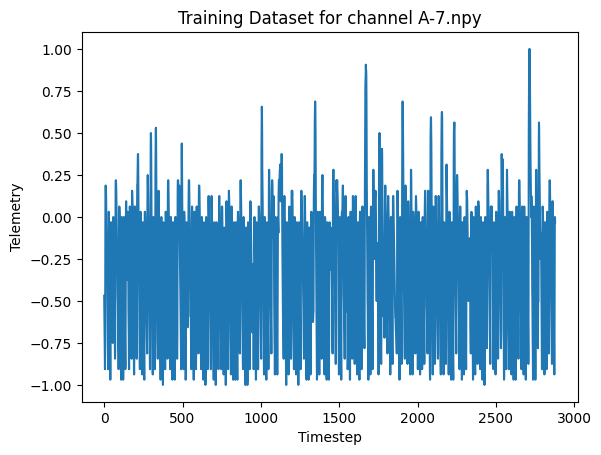

In [107]:
plt.plot(telemetry_train)

# Add labels and title
plt.xlabel('Timestep')
plt.ylabel('Telemetry')
plt.title(f'Training Dataset for channel {channel}')

# Display the plot
plt.show()


In [108]:
test_df = distances_recon_concat_ground_truth(test_df, labeled_anomalies, channel[:-4])


In [109]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,-0.469263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.562950,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.625397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.719065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.812722,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [110]:
train_df[0].value_counts()

0
-0.031908    148
-0.000658    126
 0.030593    115
-0.063156    112
-0.125649     96
            ... 
 0.812280      1
 0.906132      1
 0.780997      1
 0.937420      1
 0.968709      1
Name: count, Length: 64, dtype: int64

In [111]:
# Extract the first column and the 'actual_anomaly' column
telemetry_test = test_df.iloc[:, 0]
actual_anomaly = test_df['actual_anomaly']

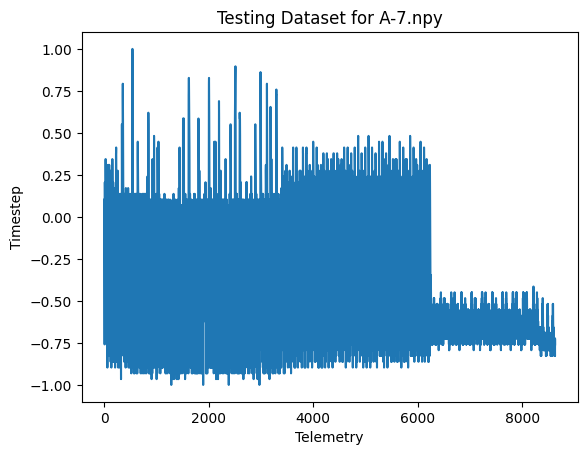

In [112]:
# Plat telemetry_test without actual anomaly
plt.plot(telemetry_test, label='Telemetry')
# Add labels and title
plt.xlabel('Telemetry')
plt.ylabel('Timestep')
plt.title(f'Testing Dataset for {channel}')

# Display the plot
plt.show()

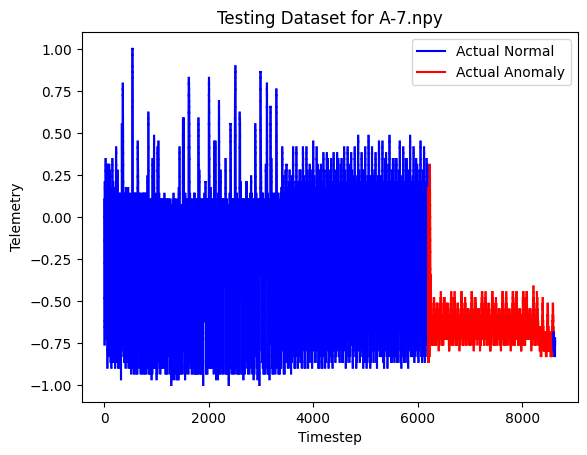

In [116]:
import matplotlib.lines as mlines

# Create a plot
plt.figure()

# Plot each point/segment with the appropriate color
for i in range(len(telemetry_test)-1):
    plt.plot([i, i+1], [telemetry_test.iloc[i], telemetry_test.iloc[i+1]], 
             color='red' if actual_anomaly.iloc[i] else 'blue')

# Add labels and title
plt.ylabel('Telemetry')
plt.xlabel('Timestep')
plt.title(f'Testing Dataset for {channel}')

# Create custom legend
blue_line = mlines.Line2D([], [], color='blue', markersize=15, label='Actual Normal')
red_line = mlines.Line2D([], [], color='red', markersize=15, label='Actual Anomaly')
plt.legend(handles=[blue_line, red_line])

# Display the plot
plt.show()

In [114]:
test_df.drop(columns=['actual_anomaly'], inplace=True)

In [115]:
test_df.shape

(8631, 25)